<a href="https://colab.research.google.com/github/simecek/dspracticum2023/blob/main/lesson04/Save_finetuned_CNN_and_run_Gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to fine-tune trained CNN model to your own (small) dataset. Because you probably do not have your data ready to train, we will create a new dataset by image search (DuckDuckGo). The notebook is a slight modification of Jeremy Howard's [Is it bird or not?](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) notebook from [Fastai course](https://course.fast.ai/).

First, let us install a few packages that are missing on Colab.

In [ ]:
!pip install -qq timm duckduckgo_search
# ignore pip's dependency error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00


## Step 1: Searching and downloading images with DuckDuckGo

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for one photo of bird

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg'

...and then download a URL and take a look at it:

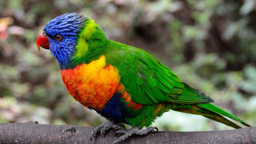

In [ ]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with a "forest photo":

Searching for 'forest photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


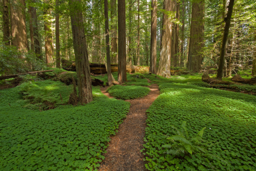

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

## Exercise

Now it is your turn to decide on 2-3 classes of images you want to classify. For example...

*   photos of bird vs. photo of forest
*   architecture styles of historical buildings (Gothic, Renaissance & Baroque)
*   photos of Bill Gates vs John Rambo
*   histology images of kidney, liver and spleen



In [ ]:
# CHANGE THIS TO YOUR CATEGORIES
searches = 'bird', 'cat', 'dog'


path = Path('image_dataset')
from time import sleep

for o in searches:
    search_query = f'{o} picture' # YOU MIGHT ALSO WANT TO MODIFY THIS
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(search_query, max_images=200))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bird picture'
Searching for 'cat picture'
Searching for 'dog picture'


In [ ]:
!ls {path}

bird  cat  dog


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

## Step 2: Train your model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

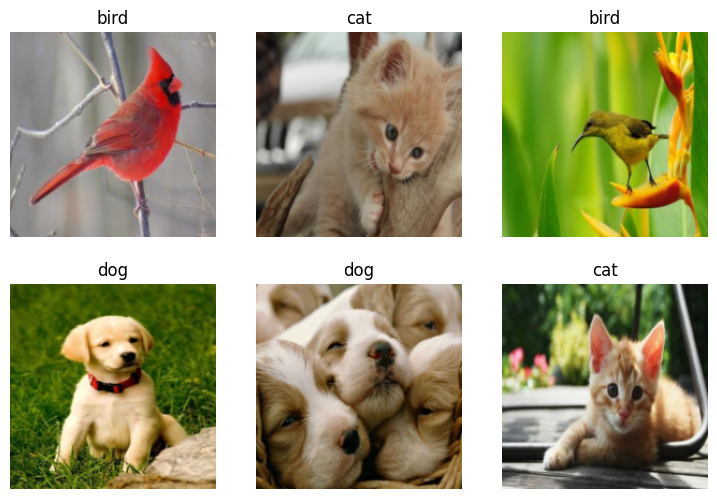

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...). If you want to select appropriate computer vision model for your purposes, [this notebook](https://www.kaggle.com/code/jhoward/which-image-models-are-best) examined a large collection of models in `timm` package.

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
# for real data, change resnet18 for better (larger) model
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,1.110143,0.052102,0.980769,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.151564,0.066282,0.980769,00:02
1,0.079561,0.031101,0.980769,00:02
2,0.076748,0.014608,1.000000,00:01


If the tast was simple (as bird vs forrest), there is a good chance to get a perfect classification. For more complex tasks, it is good to analyze the errors your neural network is doing, for example - the confusion matrix.

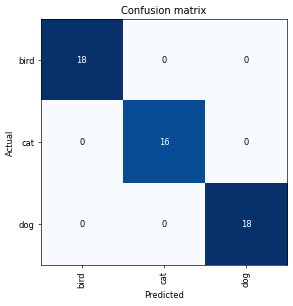

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

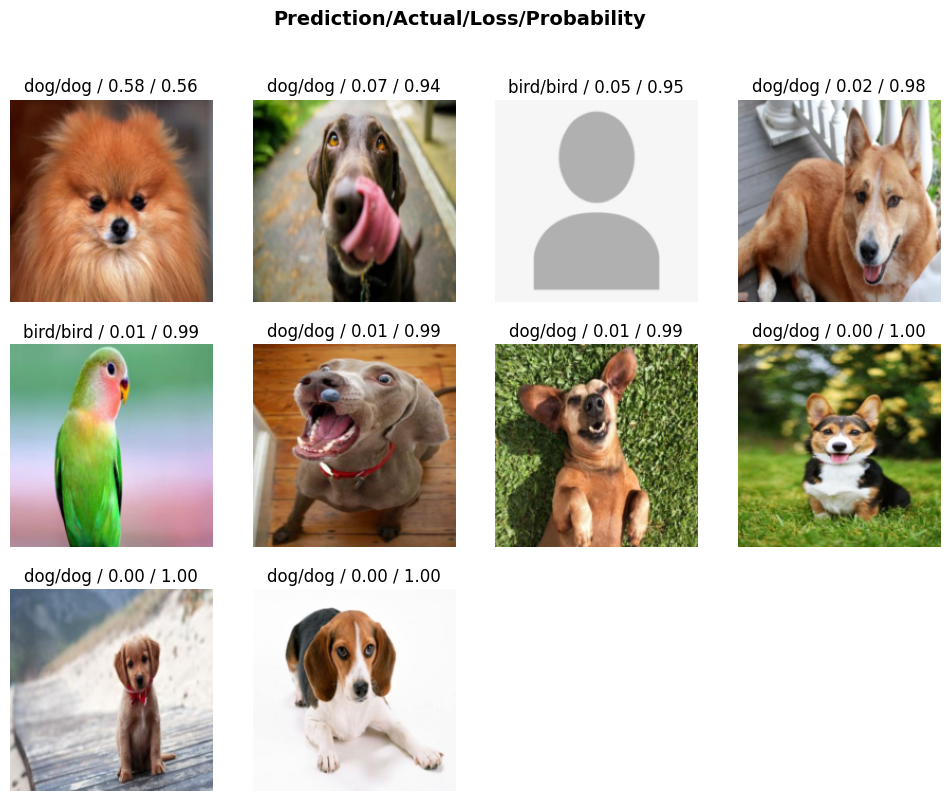

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(10)

How you can improve the training in real situation (see [Fastai book](https://github.com/fastai/fastbook)):

*   Use more data and more comple model architecture
*   Use more image transformations
*   Search for optimal learning rate (or other hyperparameters)
*   Remove wrong data points from the training set



## Step 3: Use your model

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Screenshot from 2023-10-09 00-36-01.png to Screenshot from 2023-10-09 00-36-01.png


In [ ]:
is_class,_,probs = learn.predict(PILImage.create(list(uploaded.keys())[0]))
print(f"This is a {is_class}.")
print(f"Probability it's a {is_class}: {probs.max():.4f}")

This is a dog.
Probability it's a dog: 0.9556


Good job, resnet18. :)

Also, you can save your trained model for using it later (for example building a web app based on it)...

In [ ]:
learn.export('model.pkl')

## Step 4: Gradio

In [ ]:
!pip install -qq gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.7 MB/s eta 0:00:00


To create Gradio app, two things need to be specified:


*   Input(s) and output types (interface)
*   A function that will process input into output

In [ ]:
# all possible lables
categories = learn.dls.vocab  # bird, cat, dog

examples = ['bird.jpg']

# function for the prediction
def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [ ]:
from gradio import Interface, components

image = components.Image(shape=(192, 192))
label = components.Label()

intf = Interface(
    fn=classify_image, inputs=[image], outputs=[label], examples=examples
)

intf.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://17c7aa89813f76400e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://17c7aa89813f76400e.gradio.live
